In [55]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch.optim as optim
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [56]:
# Load data
df = pd.read_csv('./Datasets/master_csv.csv')

# Choose features
imu_features = [
    'accel_y', 'accel_x', 'accel_z',
    'gyro_x', 'gyro_z', 'gyro_y'
]
target_column = 'filtered_emg'

# Use segment UIDs to split at the segment level
segment_uids = df['Segment UID'].unique()

# 80-20 split
train_uids, val_uids = train_test_split(segment_uids, test_size=0.2, random_state=42)

# Prepare training data
train_imu_segments = []
train_emg_segments = []

for segment_uid in train_uids:
    segment_df = df[df['Segment UID'] == segment_uid]
    imu_data = segment_df[imu_features].values
    emg_data = segment_df[target_column].values
    train_imu_segments.append(imu_data)
    train_emg_segments.append(emg_data)

# Prepare validation data
val_imu_segments = []
val_emg_segments = []

for segment_uid in val_uids:
    segment_df = df[df['Segment UID'] == segment_uid]
    imu_data = segment_df[imu_features].values
    emg_data = segment_df[target_column].values
    val_imu_segments.append(imu_data)
    val_emg_segments.append(emg_data)

print(f"Number of training segments: {len(train_imu_segments)}")
print(f"Number of validation segments: {len(val_imu_segments)}")


Number of training segments: 285
Number of validation segments: 72


In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# Option 1: Windowed WaveNet with Global Context
class WindowedWaveNet(nn.Module):
    def __init__(self, imu_features, hidden_channels=64, num_blocks=5, kernel_size=2, window_size=64):
        super(WindowedWaveNet, self).__init__()
        self.name = "WindowedWaveNet"
        self.window_size = window_size
        self.input_conv = nn.Conv1d(imu_features, hidden_channels, kernel_size=1)
        
        # WaveNet blocks with increasing dilation
        self.blocks = nn.ModuleList([
            WaveNetBlock(hidden_channels, hidden_channels, kernel_size, dilation=2**i)
            for i in range(num_blocks)
        ])
        
        # Global context layer to capture long-range dependencies
        self.global_context = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Conv1d(hidden_channels, hidden_channels // 4, 1),
            nn.ReLU(),
            nn.Conv1d(hidden_channels // 4, hidden_channels, 1),
            nn.Sigmoid()
        )
        
        self.output_conv = nn.Conv1d(hidden_channels, 1, kernel_size=1)

    def forward(self, x):
        # x: (batch_size, seq_len, imu_features)
        batch_size, seq_len, features = x.shape
        
        # Pad sequence for windowing if needed
        if seq_len < self.window_size:
            padding = self.window_size - seq_len
            x = F.pad(x, (0, 0, 0, padding), mode='replicate')
            seq_len = self.window_size
        
        x = x.transpose(1, 2)  # (batch_size, imu_features, seq_len)
        x = self.input_conv(x)
        
        # Process through WaveNet blocks
        for block in self.blocks:
            x = block(x)
        
        # Apply global context attention
        context = self.global_context(x)
        x = x * context
        
        x = self.output_conv(x)
        x = x.transpose(1, 2)  # (batch_size, seq_len, 1)
        
        return x


# Option 2: WaveNet + Transformer Hybrid
class WaveNetTransformerBlock(nn.Module):
    def __init__(self, hidden_channels, num_heads=8, dropout=0.1):
        super(WaveNetTransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(
            hidden_channels, num_heads, dropout=dropout, batch_first=True
        )
        self.norm1 = nn.LayerNorm(hidden_channels)
        self.norm2 = nn.LayerNorm(hidden_channels)
        
        self.ffn = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels * 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_channels * 4, hidden_channels),
            nn.Dropout(dropout)
        )

    def forward(self, x, mask=None):
        # x: (batch_size, seq_len, hidden_channels)
        # Self-attention
        attn_out, _ = self.attention(x, x, x, key_padding_mask=mask)
        x = self.norm1(x + attn_out)
        
        # Feed-forward network
        ffn_out = self.ffn(x)
        x = self.norm2(x + ffn_out)
        
        return x


class IMU2EMG_WaveNetTransformer(nn.Module):
    def __init__(self, imu_features, hidden_channels=64, num_wavenet_blocks=3, 
                 num_transformer_blocks=2, num_heads=8, kernel_size=2, dropout=0.1):
        super(IMU2EMG_WaveNetTransformer, self).__init__()
        self.name = "IMU2EMG_WaveNetTransformer"
        
        self.input_conv = nn.Conv1d(imu_features, hidden_channels, kernel_size=1)
        
        # WaveNet blocks for local feature extraction
        self.wavenet_blocks = nn.ModuleList([
            WaveNetBlock(hidden_channels, hidden_channels, kernel_size, dilation=2**i)
            for i in range(num_wavenet_blocks)
        ])
        
        # Transformer blocks for global context
        self.transformer_blocks = nn.ModuleList([
            WaveNetTransformerBlock(hidden_channels, num_heads, dropout)
            for _ in range(num_transformer_blocks)
        ])
        
        # Positional encoding
        self.pos_encoding = PositionalEncoding(hidden_channels, dropout)
        
        self.output_conv = nn.Conv1d(hidden_channels, 1, kernel_size=1)

    def forward(self, x, pad_mask=None):
        # x: (batch_size, seq_len, imu_features)
        batch_size, seq_len, _ = x.shape
        
        # WaveNet processing
        x = x.transpose(1, 2)  # (batch_size, imu_features, seq_len)
        x = self.input_conv(x)
        
        for block in self.wavenet_blocks:
            x = block(x)
        
        # Prepare for transformer
        x = x.transpose(1, 2)  # (batch_size, seq_len, hidden_channels)
        x = self.pos_encoding(x)
        
        # Transformer processing
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x, mask=pad_mask)
        
        # Output
        x = x.transpose(1, 2)  # (batch_size, hidden_channels, seq_len)
        x = self.output_conv(x)
        x = x.transpose(1, 2)  # (batch_size, seq_len, 1)
        
        return x


# Option 3: Sliding Window WaveNet (Fixed)
class SlidingWindowWaveNet(nn.Module):
    def __init__(self, imu_features, hidden_channels=64, num_blocks=5, 
                 kernel_size=2, window_size=32):
        super(SlidingWindowWaveNet, self).__init__()
        self.window_size = window_size
        self.name = "SlidingWindowWaveNet"
        
        self.input_conv = nn.Conv1d(imu_features, hidden_channels, kernel_size=1)
        
        self.blocks = nn.ModuleList([
            WaveNetBlock(hidden_channels, hidden_channels, kernel_size, dilation=2**i)
            for i in range(num_blocks)
        ])
        
        # Context aggregation with same padding to preserve sequence length
        self.context_conv = nn.Conv1d(hidden_channels, hidden_channels, 
                                    kernel_size=window_size, stride=1, 
                                    padding=window_size//2)
        
        self.output_conv = nn.Conv1d(hidden_channels, 1, kernel_size=1)

    def forward(self, x):
        # x: (batch_size, seq_len, imu_features)
        original_seq_len = x.shape[1]
        x = x.transpose(1, 2)  # (batch_size, imu_features, seq_len)
        x = self.input_conv(x)
        
        # Store original for skip connection
        skip_connections = []
        
        for block in self.blocks:
            x = block(x)
            skip_connections.append(x)
        
        # Combine skip connections
        skip_sum = sum(skip_connections)
        
        # Apply context-aware convolution
        x = self.context_conv(skip_sum)
        
        # Ensure output length matches input length
        if x.shape[2] != original_seq_len:
            x = x[:, :, :original_seq_len]
        
        x = self.output_conv(x)
        x = x.transpose(1, 2)  # (batch_size, seq_len, 1)
        
        return x

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super(MultiHeadSelfAttention, self).__init__()
        assert d_model % num_heads == 0
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(d_model)
        
    def forward(self, x, mask=None):
        batch_size, seq_len, d_model = x.size()
        
        # Store residual connection
        residual = x
        
        # Apply layer norm first (pre-norm architecture)
        x = self.layer_norm(x)
        
        # Linear transformations and split into heads
        Q = self.W_q(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        
        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        # Apply mask if provided
        if mask is not None:
            # mask shape: (batch_size, seq_len) -> expand to (batch_size, num_heads, seq_len, seq_len)
            mask = mask.unsqueeze(1).unsqueeze(2)  # (batch_size, 1, 1, seq_len)
            mask = mask.expand(batch_size, self.num_heads, seq_len, seq_len)
            scores.masked_fill_(mask, -1e9)
        
        attention_weights = torch.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        
        # Apply attention to values
        context = torch.matmul(attention_weights, V)
        
        # Concatenate heads and apply output projection
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, d_model)
        output = self.W_o(context)
        
        # Residual connection
        return output + residual

class TransformerEnhancedWaveNet(nn.Module):
    def __init__(self, imu_features, hidden_channels=64, num_blocks=5, 
                 kernel_size=2, window_size=32, num_transformer_layers=2, 
                 num_heads=8, dropout=0.1):
        super(TransformerEnhancedWaveNet, self).__init__()
        self.name = "TransformerEnhancedWaveNet"
        self.window_size = window_size
        self.hidden_channels = hidden_channels
        
        # Input projection
        self.input_conv = nn.Conv1d(imu_features, hidden_channels, kernel_size=1)
        
        # WaveNet blocks for local context
        self.wavenet_blocks = nn.ModuleList([
            WaveNetBlock(hidden_channels, hidden_channels, kernel_size, dilation=2**i)
            for i in range(num_blocks)
        ])
        
        # Transformer layers for global context
        self.pos_encoding = PositionalEncoding(hidden_channels)
        self.transformer_layers = nn.ModuleList([
            MultiHeadSelfAttention(hidden_channels, num_heads, dropout)
            for _ in range(num_transformer_layers)
        ])
        
        # Context aggregation with sliding window
        self.context_conv = nn.Conv1d(hidden_channels, hidden_channels, 
                                    kernel_size=window_size, stride=1, 
                                    padding=window_size//2)
        
        # Feature fusion layer
        self.fusion_conv = nn.Conv1d(hidden_channels * 2, hidden_channels, kernel_size=1)
        self.fusion_norm = nn.BatchNorm1d(hidden_channels)
        self.fusion_activation = nn.ReLU()
        
        # Output projection
        self.output_conv = nn.Conv1d(hidden_channels, 1, kernel_size=1)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, pad_mask=None):
        # x: (batch_size, seq_len, imu_features)
        # pad_mask: (batch_size, seq_len) - True for padded positions
        
        batch_size, original_seq_len, imu_features = x.shape
        
        # === WaveNet Path (Local Context) ===
        x_conv = x.transpose(1, 2)  # (batch_size, imu_features, seq_len)
        x_conv = self.input_conv(x_conv)
        
        # Store skip connections from WaveNet blocks
        skip_connections = []
        for block in self.wavenet_blocks:
            x_conv = block(x_conv)
            skip_connections.append(x_conv)
        
        # Combine skip connections
        wavenet_features = sum(skip_connections)
        
        # Apply sliding window context
        wavenet_features = self.context_conv(wavenet_features)
        
        # Ensure output length matches input length
        if wavenet_features.shape[2] != original_seq_len:
            wavenet_features = wavenet_features[:, :, :original_seq_len]
        
        # === Transformer Path (Global Context) ===
        # Use the initial conv features for transformer
        x_transformer = x_conv.transpose(1, 2)  # (batch_size, seq_len, hidden_channels)
        
        # Add positional encoding
        x_transformer = x_transformer.transpose(0, 1)  # (seq_len, batch_size, hidden_channels)
        x_transformer = self.pos_encoding(x_transformer)
        x_transformer = x_transformer.transpose(0, 1)  # (batch_size, seq_len, hidden_channels)
        
        # Apply transformer layers
        for transformer_layer in self.transformer_layers:
            x_transformer = transformer_layer(x_transformer, pad_mask)
        
        x_transformer = self.dropout(x_transformer)
        x_transformer = x_transformer.transpose(1, 2)  # (batch_size, hidden_channels, seq_len)
        
        # === Feature Fusion ===
        # Concatenate WaveNet and Transformer features
        fused_features = torch.cat([wavenet_features, x_transformer], dim=1)
        
        # Fusion layer to combine both contexts
        fused_features = self.fusion_conv(fused_features)
        fused_features = self.fusion_norm(fused_features)
        fused_features = self.fusion_activation(fused_features)
        
        # Final output projection
        output = self.output_conv(fused_features)
        output = output.transpose(1, 2)  # (batch_size, seq_len, 1)
        
        return output

class IMU2EMG_WaveNet(nn.Module):
    def __init__(self, imu_features, hidden_channels=64, num_blocks=5, kernel_size=2):
        super(IMU2EMG_WaveNet, self).__init__()
        self.name = "IMU2EMG_WaveNet"
        self.input_conv = nn.Conv1d(imu_features, hidden_channels, kernel_size=1)
        self.blocks = nn.ModuleList([
            WaveNetBlock(hidden_channels, hidden_channels, kernel_size, dilation=2**i)
            for i in range(num_blocks)
        ])
        self.output_conv = nn.Conv1d(hidden_channels, 1, kernel_size=1)

    def forward(self, x):
        # x: (batch_size, seq_len, imu_features)
        x = x.transpose(1, 2)  # (batch_size, imu_features, seq_len)
        x = self.input_conv(x)
        for block in self.blocks:
            x = block(x)
        x = self.output_conv(x)
        x = x.transpose(1, 2)  # (batch_size, seq_len, 1)
        return x

# Utility classes

class WaveNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super(WaveNetBlock, self).__init__()
        self.causal_conv = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            padding=(kernel_size - 1) * dilation,
            dilation=dilation
        )
        self.activation = nn.ReLU()
        self.residual_conv = nn.Conv1d(out_channels, in_channels, kernel_size=1)

    def forward(self, x):
        out = self.causal_conv(x)
        out = out[:, :, :-self.causal_conv.padding[0]]  # remove padding for causality
        out = self.activation(out)
        res = self.residual_conv(out)
        return res + x  # residual connection
    

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                           (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(1), :].transpose(0, 1)
        return self.dropout(x)

In [58]:
class IMU_EMG_Dataset(Dataset):
    def __init__(self, imu_segments, emg_segments):
        self.imu_segments = imu_segments
        self.emg_segments = emg_segments

    def __len__(self):
        return len(self.imu_segments)

    def __getitem__(self, idx):
        imu = torch.tensor(self.imu_segments[idx], dtype=torch.float32)   # shape: (seq_len, imu_features)
        emg = torch.tensor(self.emg_segments[idx], dtype=torch.float32)   # shape: (seq_len,)
        emg = emg.unsqueeze(-1)  # Make it (seq_len, 1) to match output shape
        return imu, emg


In [59]:
def collate_fn(batch):
    imu_batch, emg_batch = zip(*batch)
    
    # Pad sequences to the max length in this batch
    imu_batch_padded = pad_sequence(imu_batch, batch_first=True)     # (batch_size, max_seq_len, imu_features)
    emg_batch_padded = pad_sequence(emg_batch, batch_first=True)     # (batch_size, max_seq_len, 1)

    # Create padding mask: shape (batch_size, max_seq_len)
    # False where there's real data, True where there's padding
    lengths = torch.tensor([x.shape[0] for x in imu_batch])
    max_len = imu_batch_padded.shape[1]
    pad_mask = torch.arange(max_len).expand(len(lengths), max_len) >= lengths.unsqueeze(1)
    
    return imu_batch_padded, emg_batch_padded, pad_mask



In [60]:
train_dataset = IMU_EMG_Dataset(train_imu_segments, train_emg_segments)
val_dataset = IMU_EMG_Dataset(val_imu_segments, val_emg_segments)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pywt
from scipy import signal
from scipy.stats import pearsonr

class BasicLosses:
    """Basic loss functions for wave generation"""
    
    @staticmethod
    def mse_loss(pred, target):
        """Mean Squared Error"""
        return F.mse_loss(pred, target)
    
    @staticmethod
    def mae_loss(pred, target):
        """Mean Absolute Error"""
        return F.l1_loss(pred, target)
    
    @staticmethod
    def rmse_loss(pred, target):
        """Root Mean Squared Error"""
        return torch.sqrt(F.mse_loss(pred, target))
    
    @staticmethod
    def huber_loss(pred, target, delta=1.0):
        """Huber Loss - robust to outliers"""
        return F.huber_loss(pred, target, delta=delta)

class SignalQualityLosses:
    """Signal quality based loss functions"""
    
    @staticmethod
    def snr_loss(pred, target, eps=1e-8):
        """Signal-to-Noise Ratio based loss (higher SNR = lower loss)"""
        signal_power = torch.mean(target ** 2, dim=-1, keepdim=True)
        noise_power = torch.mean((pred - target) ** 2, dim=-1, keepdim=True)
        snr = 10 * torch.log10(signal_power / (noise_power + eps))
        return -torch.mean(snr)  # Negative because we want to maximize SNR
    
    @staticmethod
    def psnr_loss(pred, target, max_val=1.0, eps=1e-8):
        """Peak Signal-to-Noise Ratio based loss"""
        mse = torch.mean((pred - target) ** 2)
        psnr = 20 * torch.log10(max_val / (torch.sqrt(mse) + eps))
        return -psnr  # Negative because we want to maximize PSNR

class CorrelationLosses:
    """Correlation-based loss functions"""
    
    @staticmethod
    def cosine_similarity_loss(pred, target, dim=-1, eps=1e-8):
        """Cosine similarity loss (1 - cosine_similarity)"""
        cos_sim = F.cosine_similarity(pred, target, dim=dim, eps=eps)
        return 1 - torch.mean(cos_sim)
    
    @staticmethod
    def pearson_correlation_loss(pred, target, eps=1e-8):
        """Pearson correlation coefficient loss"""
        # Compute means
        pred_mean = torch.mean(pred, dim=-1, keepdim=True)
        target_mean = torch.mean(target, dim=-1, keepdim=True)
        
        # Center the data
        pred_centered = pred - pred_mean
        target_centered = target - target_mean
        
        # Compute correlation
        numerator = torch.sum(pred_centered * target_centered, dim=-1)
        pred_std = torch.sqrt(torch.sum(pred_centered ** 2, dim=-1) + eps)
        target_std = torch.sqrt(torch.sum(target_centered ** 2, dim=-1) + eps)
        
        correlation = numerator / (pred_std * target_std + eps)
        return 1 - torch.mean(correlation)

class FrequencyDomainLosses:
    """Frequency domain loss functions"""
    
    @staticmethod
    def spectral_convergence_loss(pred, target, eps=1e-7):
        """Spectral convergence loss using FFT"""
        pred_fft = torch.fft.fft(pred, dim=-1)
        target_fft = torch.fft.fft(target, dim=-1)
        
        pred_mag = torch.abs(pred_fft)
        target_mag = torch.abs(target_fft)
        
        numerator = torch.norm(pred_mag - target_mag, p='fro')
        denominator = torch.norm(target_mag, p='fro')
        
        return numerator / (denominator + eps)
    
    @staticmethod
    def stft_distance_loss(pred, target, n_fft=1024, hop_length=256, win_length=1024):
        """Short-Time Fourier Transform distance loss"""
        # Create window
        window = torch.hann_window(win_length, device=pred.device)
        
        # Compute STFT
        pred_stft = torch.stft(pred.view(-1), n_fft=n_fft, hop_length=hop_length, 
                              win_length=win_length, window=window, return_complex=True)
        target_stft = torch.stft(target.view(-1), n_fft=n_fft, hop_length=hop_length,
                                win_length=win_length, window=window, return_complex=True)
        
        # Magnitude loss
        pred_mag = torch.abs(pred_stft)
        target_mag = torch.abs(target_stft)
        
        mag_loss = F.l1_loss(pred_mag, target_mag)
        
        # Phase loss (using cosine distance)
        pred_phase = torch.angle(pred_stft)
        target_phase = torch.angle(target_stft)
        phase_loss = 1 - F.cosine_similarity(pred_phase.flatten(), target_phase.flatten(), dim=0)
        
        return mag_loss + 0.1 * phase_loss

class WaveletLosses:
    """Wavelet-based loss functions"""
    
    @staticmethod
    def dwt_loss(pred, target, wavelet='db2', levels=4):
        """Discrete Wavelet Transform loss"""
        device = pred.device
        total_loss = 0
        
        # Convert to numpy for pywt
        pred_np = pred.detach().cpu().numpy()
        target_np = target.detach().cpu().numpy()
        
        batch_size = pred_np.shape[0]
        
        for i in range(batch_size):
            # Perform DWT
            pred_coeffs = pywt.wavedec(pred_np[i].flatten(), wavelet, level=levels)
            target_coeffs = pywt.wavedec(target_np[i].flatten(), wavelet, level=levels)
            
            # Compute loss for each level
            for p_coeff, t_coeff in zip(pred_coeffs, target_coeffs):
                p_tensor = torch.tensor(p_coeff, device=device, dtype=torch.float32)
                t_tensor = torch.tensor(t_coeff, device=device, dtype=torch.float32)
                total_loss += F.mse_loss(p_tensor, t_tensor)
        
        return total_loss / batch_size

class EnvelopeLosses:
    """Envelope-based loss functions"""
    
    @staticmethod
    def envelope_similarity_loss(pred, target):
        """Envelope similarity using moving average of absolute values"""
        # Ensure pred and target are 2D: (batch_size, seq_len)
        if len(pred.shape) == 1:
            pred = pred.unsqueeze(0)
        if len(target.shape) == 1:
            target = target.unsqueeze(0)
            
        batch_size, seq_len = pred.shape
        
        # Adaptive kernel size
        kernel_size = min(50, seq_len // 10)
        if kernel_size < 3:
            kernel_size = 3
        
        # Make kernel size odd for symmetric padding
        if kernel_size % 2 == 0:
            kernel_size += 1
            
        kernel = torch.ones(1, 1, kernel_size, device=pred.device) / kernel_size
        
        # Reshape for conv1d: (batch_size, 1, seq_len)
        pred_reshaped = torch.abs(pred).unsqueeze(1)
        target_reshaped = torch.abs(target).unsqueeze(1)
        
        # Apply convolution with proper padding
        padding = kernel_size // 2
        pred_env = F.conv1d(pred_reshaped, kernel, padding=padding)
        target_env = F.conv1d(target_reshaped, kernel, padding=padding)
        
        # Remove the channel dimension: (batch_size, seq_len)
        pred_env = pred_env.squeeze(1)
        target_env = target_env.squeeze(1)
        
        return F.mse_loss(pred_env, target_env)
    
    @staticmethod
    def rms_envelope_loss(pred, target, window_size=50):
        """RMS envelope loss"""
        # Ensure proper shape
        if len(pred.shape) == 1:
            pred = pred.unsqueeze(0)
        if len(target.shape) == 1:
            target = target.unsqueeze(0)
            
        batch_size, seq_len = pred.shape
        
        # Adaptive window size
        window_size = min(window_size, seq_len // 5)
        if window_size < 3:
            window_size = 3
        if window_size % 2 == 0:
            window_size += 1
        
        # Pad sequences
        pad_size = window_size // 2
        pred_padded = F.pad(pred, (pad_size, pad_size), mode='reflect')
        target_padded = F.pad(target, (pad_size, pad_size), mode='reflect')
        
        # Reshape for pooling: (batch_size, 1, seq_len)
        pred_padded = pred_padded.unsqueeze(1)
        target_padded = target_padded.unsqueeze(1)
        
        # Compute RMS envelope
        pred_rms = torch.sqrt(F.avg_pool1d(pred_padded ** 2, 
                                          kernel_size=window_size, stride=1))
        target_rms = torch.sqrt(F.avg_pool1d(target_padded ** 2,
                                            kernel_size=window_size, stride=1))
        
        # Remove channel dimension
        pred_rms = pred_rms.squeeze(1)
        target_rms = target_rms.squeeze(1)
        
        return F.mse_loss(pred_rms, target_rms)

class CompoundLosses:
    
    @staticmethod
    def compound_loss(pred, target, weights=None):
        """Compound loss combining multiple losses"""
        if weights is None:
            weights = {
                'mse': 1.0,
                'snr': 0.5,
                'cosine': 0.5,
                'spectral': 0.2,
                'envelope': 0.3
            }
        
        mse = BasicLosses.mse_loss(pred, target)
        snr = SignalQualityLosses.snr_loss(pred, target)
        cosine = CorrelationLosses.cosine_similarity_loss(pred, target)
        spectral = FrequencyDomainLosses.spectral_convergence_loss(pred, target)
        envelope = EnvelopeLosses.envelope_similarity_loss(pred, target)
        
        total_loss = (weights['mse'] * mse +
                      weights['snr'] * snr +
                      weights['cosine'] * cosine +
                      weights['spectral'] * spectral +
                      weights['envelope'] * envelope)
        
        return total_loss
    
    @staticmethod
    def Norm_Loss(pred, target):
        """
        Normalized MSE loss using min-max normalization (differentiable, torch-only).
        Scales both pred and target to [0, 1] using their own min/max, then computes MSE.
        """
        pred_min = pred.min(dim=-1, keepdim=True)[0]
        pred_max = pred.max(dim=-1, keepdim=True)[0]
        target_min = target.min(dim=-1, keepdim=True)[0]
        target_max = target.max(dim=-1, keepdim=True)[0]

        pred_norm = (pred - pred_min) / (pred_max - pred_min + 1e-8)
        target_norm = (target - target_min) / (target_max - target_min + 1e-8)

        return F.mse_loss(pred_norm, target_norm)

# Usage example with your training loop
def get_loss_function(loss_type='mse', **kwargs):
    """Factory function to get different loss functions"""
    
    loss_functions = {
        # Basic losses
        'mse': BasicLosses.mse_loss,
        'mae': BasicLosses.mae_loss,
        'rmse': BasicLosses.rmse_loss,
        'huber': lambda p, t: BasicLosses.huber_loss(p, t, **kwargs),
        
        # Signal quality
        'snr': SignalQualityLosses.snr_loss,
        'psnr': SignalQualityLosses.psnr_loss,
        
        # Correlation
        'cosine': CorrelationLosses.cosine_similarity_loss,
        'pearson': CorrelationLosses.pearson_correlation_loss,
        
        # Frequency domain
        'spectral': FrequencyDomainLosses.spectral_convergence_loss,
        'stft': FrequencyDomainLosses.stft_distance_loss,
        
        # Wavelet
        # 'dwt': WaveletLosses.dwt_loss, # This is un-usable because it requires numpy arrays and tensor to numpy conversion breaks the autograd
        
        # Envelope
        'envelope': EnvelopeLosses.envelope_similarity_loss,
        'rms_envelope': EnvelopeLosses.rms_envelope_loss,
        
        #  Custom losses
        'compound': CompoundLosses.compound_loss,  # Define this method in CompoundLosses
        'norm': CompoundLosses.Norm_Loss,
    }
    
    return loss_functions.get(loss_type, BasicLosses.mse_loss)

In [ ]:
# Modified training function for context-aware models with early stopping
def train_context_aware_model(model, train_loader, val_loader, loss_type='compund', 
                            num_epochs=100, use_transformer=False, early_stopping_patience=10, weights=None):
    """Training loop for context-aware models with early stopping"""
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Get custom loss function
    if loss_type == 'compound':
        criterion = get_loss_function('compound', weights=weights)
    else:
        criterion = get_loss_function(loss_type)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
    
    loss_history = []
    val_losses = []
    best_loss = float('inf')
    best_epoch = 0
    early_stop_counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        
        for imu_batch, emg_batch, pad_mask in train_loader:
            imu_batch = imu_batch.to(device)
            emg_batch = emg_batch.to(device)
            pad_mask = pad_mask.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass - handle different model types
            if use_transformer:
                prediction = model(imu_batch, pad_mask)
            else:
                prediction = model(imu_batch)
            
            # Ensure shapes match for masking
            if prediction.shape[1] != pad_mask.shape[1]:
                min_len = min(prediction.shape[1], pad_mask.shape[1])
                prediction = prediction[:, :min_len, :]
                emg_batch = emg_batch[:, :min_len, :]
                pad_mask = pad_mask[:, :min_len]
            
            # Apply mask - need to expand pad_mask to match prediction dimensions
            mask_expanded = ~pad_mask.unsqueeze(-1)  # Shape: [batch, seq_len, 1]
            outputs_masked = prediction[mask_expanded]
            emg_masked = emg_batch[mask_expanded]
            
            # Calculate loss
            loss = criterion(outputs_masked, emg_masked)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_epoch_loss = epoch_loss / len(train_loader)
        loss_history.append(avg_epoch_loss)

        # Validation loop
        if val_loader is not None:
            model.eval()
            total_val_loss = 0
            num_val_batches = 0
            
            with torch.no_grad():
                for imu_batch, emg_batch, pad_mask in val_loader:
                    imu_batch = imu_batch.to(device)
                    emg_batch = emg_batch.to(device)
                    pad_mask = pad_mask.to(device)
                    
                    if use_transformer:
                        predictions = model(imu_batch, pad_mask)
                    else:
                        predictions = model(imu_batch)
                    
                    # Ensure shapes match
                    if predictions.shape[1] != pad_mask.shape[1]:
                        min_len = min(predictions.shape[1], pad_mask.shape[1])
                        predictions = predictions[:, :min_len, :]
                        emg_batch = emg_batch[:, :min_len, :]
                        pad_mask = pad_mask[:, :min_len]
                    
                    loss_mask = ~pad_mask.unsqueeze(-1)
                    val_loss = criterion(predictions[loss_mask], emg_batch[loss_mask])
                    
                    total_val_loss += val_loss.item()
                    num_val_batches += 1
            
            avg_val_loss = total_val_loss / num_val_batches
            val_losses.append(avg_val_loss)

            scheduler.step(avg_val_loss)
            print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_epoch_loss:.6f} | Val Loss: {avg_val_loss:.6f} | LR: {optimizer.param_groups[0]["lr"]:.6f}')
        else:
            scheduler.step(avg_epoch_loss)
            print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_epoch_loss:.6f} | LR: {optimizer.param_groups[0]["lr"]:.6f}')
            avg_val_loss = avg_epoch_loss  # For early stopping if no val_loader
        
        # Early stopping logic
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            best_epoch = epoch
            early_stop_counter = 0
            torch.save(model.state_dict(), f'./model_checkpoint/model_best_{model.name}_{loss_type}_all.pth')
            print(f"Best model saved with {loss_type} loss: {best_loss:.4f}")
        else:
            early_stop_counter += 1
            if early_stop_counter >= early_stopping_patience:
                print(f"Early stopping triggered at epoch {epoch+1}. Best epoch: {best_epoch+1} with loss: {best_loss:.4f}")
                break
    
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history, label='Train Loss')
    if val_loader is not None:
        plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [69]:
# Example usage:

# Option 1: Windowed WaveNet
model1 = WindowedWaveNet(imu_features=len(imu_features), hidden_channels=64, window_size=64, num_blocks=5, kernel_size=8)

# Option 2: WaveNet + Transformer
model2 = IMU2EMG_WaveNetTransformer(imu_features=len(imu_features), hidden_channels=64, 
                                   num_wavenet_blocks=5, num_transformer_blocks=3, kernel_size=8, num_heads=8, dropout=0.1)

# Option 3: Sliding Window WaveNet
model3 = SlidingWindowWaveNet(imu_features=len(imu_features), hidden_channels=64, window_size=10, kernel_size=2, num_blocks=5)

model4 = TransformerEnhancedWaveNet(imu_features=len(imu_features), hidden_channels=64,
                                    num_blocks=5, kernel_size=8, window_size=10,
                                    num_transformer_layers=3, num_heads=8, dropout=0.1)

model5 = IMU2EMG_WaveNet(imu_features=len(imu_features), hidden_channels=64, num_blocks=5, kernel_size=8)

Epoch 1/1000 | Train Loss: 950.305428 | Val Loss: 477.494002 | LR: 0.000500
Best model saved with mse loss: 477.4940
Epoch 2/1000 | Train Loss: 469.659741 | Val Loss: 321.258362 | LR: 0.000500
Best model saved with mse loss: 321.2584
Epoch 3/1000 | Train Loss: 354.788412 | Val Loss: 307.540534 | LR: 0.000500
Best model saved with mse loss: 307.5405
Epoch 4/1000 | Train Loss: 295.209504 | Val Loss: 310.343645 | LR: 0.000500
Epoch 5/1000 | Train Loss: 293.419019 | Val Loss: 367.303687 | LR: 0.000500
Epoch 6/1000 | Train Loss: 287.968502 | Val Loss: 301.096944 | LR: 0.000500
Best model saved with mse loss: 301.0969
Epoch 7/1000 | Train Loss: 266.739444 | Val Loss: 299.316328 | LR: 0.000500
Best model saved with mse loss: 299.3163
Epoch 8/1000 | Train Loss: 266.157535 | Val Loss: 296.565369 | LR: 0.000500
Best model saved with mse loss: 296.5654
Epoch 9/1000 | Train Loss: 262.753705 | Val Loss: 299.125576 | LR: 0.000500
Epoch 10/1000 | Train Loss: 260.116705 | Val Loss: 295.022627 | LR: 0.

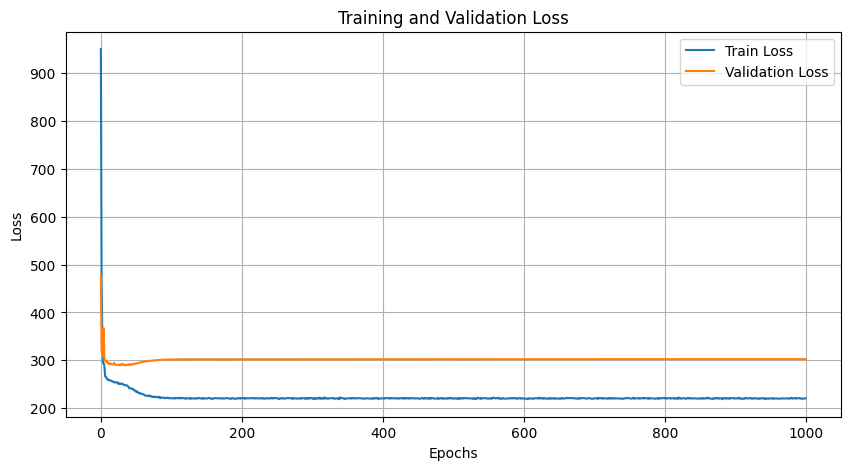

In [70]:
# Training
loss_type = 'mse'  # Choose from 'mse', 'mae', 'rmse', 'huber', 'snr', 'psnr', 'cosine', 'pearson', 'spectral', 'stft', 'envelope', 'rms_envelope', 'compound', or 'norm'
train_context_aware_model(model3, train_loader, val_loader, loss_type=loss_type, num_epochs=1000, early_stopping_patience=999)

In [71]:
# Recreate the model architecture
model = SlidingWindowWaveNet(imu_features=len(imu_features), hidden_channels=64, window_size=10, kernel_size=2, num_blocks=5)

model.load_state_dict(torch.load(f'./model_checkpoint/model_best_{model.name}_{loss_type}_all.pth'))

<All keys matched successfully>

In [72]:
def predict_emg(model, imu_data, device):
    """
    Predict EMG from IMU data
    
    Args:
        model: Trained WaveNet model
        imu_data: numpy array of shape (seq_len, features) or (batch_size, seq_len, features)
        device: torch device
    
    Returns:
        numpy array of predicted EMG values
    """
    model.eval()
    
    # Convert to tensor
    if isinstance(imu_data, np.ndarray):
        imu_tensor = torch.tensor(imu_data, dtype=torch.float32)
    else:
        imu_tensor = imu_data
    
    # Add batch dimension if needed
    if len(imu_tensor.shape) == 2:
        imu_tensor = imu_tensor.unsqueeze(0)
    
    imu_tensor = imu_tensor.to(device)
    
    # Make prediction
    with torch.no_grad():
        prediction = model(imu_tensor)
    
    # Convert to numpy and remove extra dimensions
    prediction_np = prediction.cpu().numpy().squeeze()
    
    return prediction_np  # Normalize to start from zero

In [73]:
from sklearn.preprocessing import MinMaxScaler

idx = 3

scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()
predicted_emg = predict_emg(model, val_imu_segments[idx], 'cpu')
true_emg = np.array(val_emg_segments[idx]).reshape(-1, 1)
pred_emg = predicted_emg.reshape(-1, 1)

# Fit scaler on both arrays concatenated to ensure same scale
scaler1.fit(true_emg)
scaler2.fit(pred_emg)
true_emg_norm = scaler1.transform(true_emg).flatten()
pred_emg_norm = scaler2.transform(pred_emg).flatten()

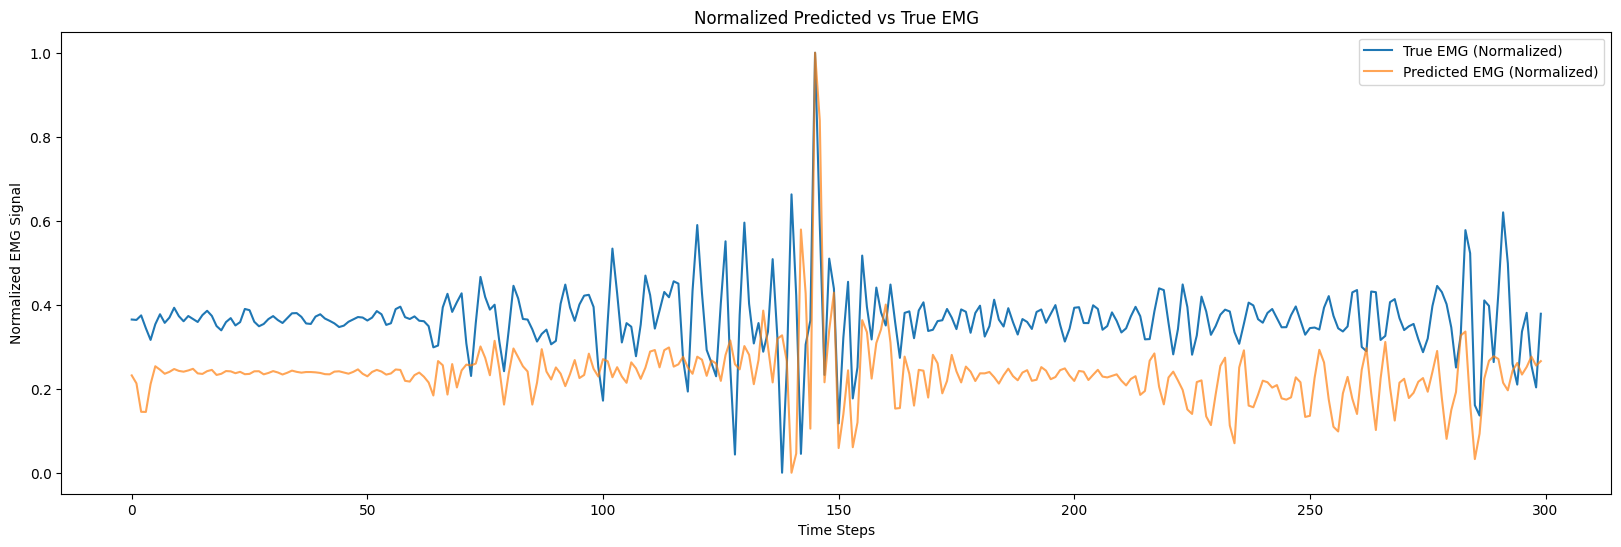

In [74]:
plt.figure(figsize=(20, 6))
plt.plot(true_emg_norm, label='True EMG (Normalized)')
plt.plot(pred_emg_norm, label='Predicted EMG (Normalized)', alpha=0.7)
plt.title('Normalized Predicted vs True EMG')
plt.xlabel('Time Steps')
plt.ylabel('Normalized EMG Signal')
plt.legend()

# Rankings based on 500 epochs

### I have scored based on prediction on segment[1] for all

|loss type|rmse|R2|
|----|----|----|
|snr|0.04798967415894167|0.918160966385193|
|mse|0.0676467455444179|0.8325614014050449|
|rmse|0.06822457971374514|0.8311655891200165|
|mae|0.087928514185403|0.7300305778934999|
|psnr|0.08501082328447777|0.7024841206195498|
|huber|0.11503663507459132|0.5418107926881377|
|Cosine|0.1335801753269996|0.3821877233468024|
|pearson|0.15102031751817505|0.21033430111035145|
|Spectral|0.15760163012993206|-0.10498374453305281|
|stft|0.1812565448404956|-0.13752227529011685|
|envelope|0.22726215897170043|-0.7882439809870803|
|rms_envelope|0.2414003990902322|-1.017662318146646|

